In [1]:
# Dependencies
# !pip install langchain unstructured[pdf] langchain_community langchain_openai chromadb tesseract
# !apt-get update && apt-get install ffmpeg libsm6 libxext6 poppler-utils tesseract-ocr python3-pil

# OpenAI API Key if using GPT-4o, otherwise can skip
# !export OPENAI_API_KEY="my-key"

# Install Ollama
# !curl -fsSL https://ollama.com/install.sh | sh
# !ollama pull llava:7b
# !ollama run llava:7b

In [2]:
from langchain.text_splitter import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf


# Extract elements from PDF
def extract_pdf_elements(fname):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    return partition_pdf(fname,
                       extract_images_in_pdf=True,
                       infer_table_structure=True,
                       strategy="auto",
                        max_characters=4000,
                        new_after_n_chars=3800,
                        combine_text_under_n_chars=2000
    )


# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    
    texts = []
    tables = []
    # images = []
    formulas = []

    text_elements = ['Text','NarrativeText', 'FigureCaption', 'Title', 'ListItem']
    text_elements = ["unstructured.documents.elements." + tt for tt in text_elements]
    
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif str(type(element))[8:-2] in text_elements:
            texts.append(str(element))
        elif "unstructured.documents.elements.Formula" in str(type(element)):
            formulas.append(str(element))
    return texts, tables, formulas


# File path
fname = "Attention_is_all_you_need.pdf"

# Get elements
raw_pdf_elements = extract_pdf_elements(fname)

# Split elements into various objects:
texts, tables, formulas = categorize_elements(raw_pdf_elements)

# Optional: Enforce a specific token size for texts
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2048, chunk_overlap=96
)

joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

/home/ubuntu/miniconda3/envs/pdf-rag/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetectio

In [3]:
# Convert elements to Markdown
markdown_content = "\n\n".join([str(element) for element in raw_pdf_elements])


# Save the Markdown content to a file
with open("output.md", "w") as md_file:
    md_file.write(markdown_content)

In [4]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
import os

text_summary_model = 'llama3.1:8b'
text_emb_model = 'snowflake-arctic-embed'
image_summary_model = 'llava:34b'
mm_rag_llm_model = 'llava:34b'

# OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    # model = ChatOpenAI(temperature=0, api_key="my-key", model="gpt-4")
    model = ChatOpenAI(
        temperature=0, 
        base_url='http://localhost:11434/v1/',
        model=text_summary_model,
        api_key="ollama",
    )
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

In [5]:
import base64
import os
from langchain_openai import ChatOpenAI

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    # chat = ChatOpenAI(model="gpt-4o", api_key="my-key", max_tokens=200)
    chat = ChatOpenAI(
        base_url='http://localhost:11434/v1/',
        model=image_summary_model,
        api_key="ollama",
        max_tokens=200
    )

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    from tqdm import tqdm
    import time

    prompt = """You are an assistant tasked with summarizing images for retrieval. \
        These summaries will be embedded and used to retrieve the raw image. \
        Give a detailed summary of the image that is well optimized for retrieval. \
        Make sure you describe every component of the image and any relevant relationships \
        those components may have with each other. """

    count = 0

    for img_file in tqdm(sorted(os.listdir(path)), desc="Processing images"):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)

            try:
                base64_image = encode_image(img_path)
                img_base64_list.append(base64_image)
                image_summaries.append(image_summarize(base64_image, prompt))
                count += 1

            except Exception as e:
                print(f"Error processing image {img_file}: {e}")

    return img_base64_list, image_summaries


# Image summaries
# img_base64_list, image_summaries = generate_img_summaries("/home/ubuntu/btong/pdf-rag/figures")
img_base64_list, image_summaries = generate_img_summaries("./figures")
image_summaries

Processing images: 100%|█████████████████████████████████| 7/7 [00:35<00:00,  5.07s/it]


["This is an image demonstrating a visualization technique commonly referred to as word embeddings or term vector distributions. The purpose of this image is not fully clear without additional context since the content is extremely compact and small elements. However, it seems that the technique plots various documents (or datasets containing terms) in a two-dimensional space according to their similarity. The colors might represent clusters or groups, while density visualization suggests the frequency of the different data points. If I am understanding correctly, this image could be used for comparing and analyzing text data using vector analysis. It's a valuable method in fields like machine learning or data science where one aims to understand and model semantic relationships between words or phrases within documents or collections of data texts.",
 '',
 'The image appears to be a flowchart or diagram with a background filled in with a warm color that fades from one edge towards the

In [6]:
import uuid, os

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
# from langchain_openai import OpenAIEmbeddings

from langchain_ollama import OllamaEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="rag-storage", embedding_function=OllamaEmbeddings(model=text_emb_model)
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list
)

/tmp/ipykernel_9104/3429031049.py:55: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  vectorstore = Chroma(


In [7]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are a deep learning and machine learning specialist.\n"
            "You may be given a mixed of text, tables, and images.\n"
            "Use this information to provide quality information related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    # model = ChatOpenAI(temperature=0, model="gpt-4o", api_key="my-key", max_tokens=1024)
    model = ChatOpenAI(
        temperature=0, 
        base_url='http://localhost:11434/v1/',
        model=mm_rag_llm_model,
        api_key="ollama",
        max_tokens=1024
    )

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

# Check the Multi-modal Retrieval

/tmp/ipykernel_9104/1922980052.py:14: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  docs = retriever_multi_vector_img.get_relevant_documents(query, limit=6)


Number of relevant docs found: 4

The BLEU score for the ByteNet model is 23.75, as shown in the table provided. The table compares various models and their performance metrics such as BLEU scores, training costs (FLOPs), and other relevant statistics across different language pairs like EN-DE (English to German) and EN-FR (English to French).

Documents retrieved:

Model BLEU EN-DE EN-FR Training Cost (FLOPs) EN-DE EN-FR ByteNet [18] 23.75 Deep-Att + PosUnk [39] 39.2 1.0 · 1020 GNMT + RL [38] 24.6 39.92 2.3 · 1019 1.4 · 1020 ConvS2S [9] 25.16 40.46 9.6 · 1018 1.5 · 1020 MoE [32] 26.03 40.56 2.0 · 1019 1.2 · 1020 Deep-Att + PosUnk Ensemble [39] 40.4 8.0 · 1020 GNMT + RL Ensemble [38] 26.30 41.16 1.8 · 1020 1.1 · 1021 ConvS2S Ensemble [9] 26.36 41.29 7.7 · 1019 1.2 · 1021 Transformer (base model) 27.3 38.1 3.3 · 1018 Transformer (big) 28.4 41.8 2.3 · 1019


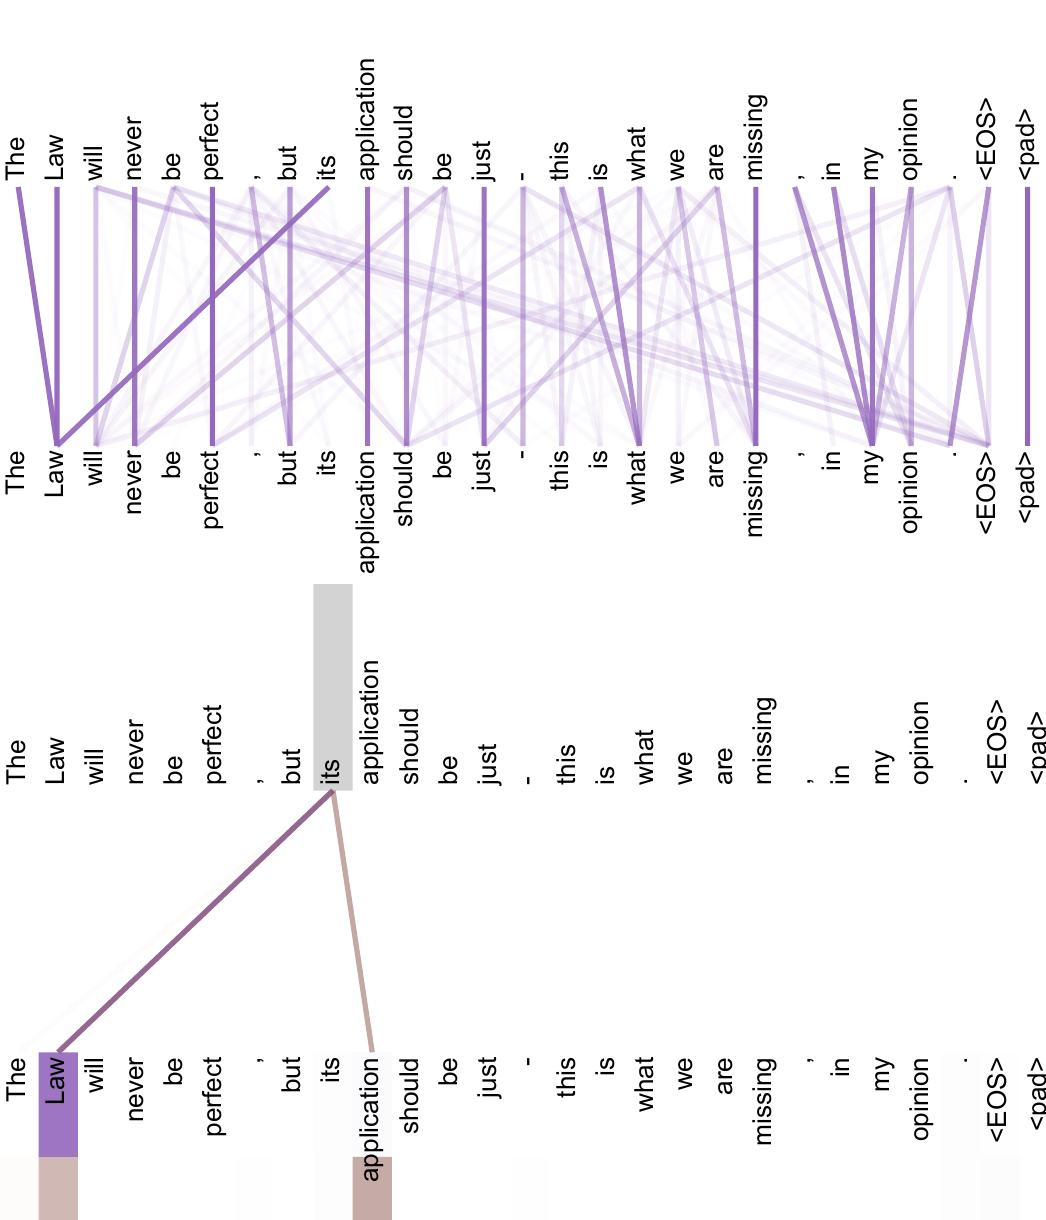


N dmodel dff h dk dv Pdrop ϵls train steps PPL (dev) BLEU params (dev) ×106 base 6 512 2048 8 64 64 0.1 0.1 100K 4.92 25.8 65 1 512 512 5.29 24.9 (A) 4 16 128 32 128 32 5.00 4.91 25.5 25.8 32 16 16 5.01 25.4 (B) 16 32 5.16 5.01 25.1 25.4 58 60 2 6.11 23.7 36 4 5.19 25.3 50 8 4.88 25.5 80 (C) 256 32 32 5.75 24.5 28 1024 128 128 4.66 26.0 168 1024 5.12 25.4 53 4096 4.75 26.2 90 0.0 5.77 24.6 (D) 0.2 0.0 4.95 4.67 25.5 25.3 0.2 5.47 25.7 (E) positional embedding instead of sinusoids 4.92 25.7


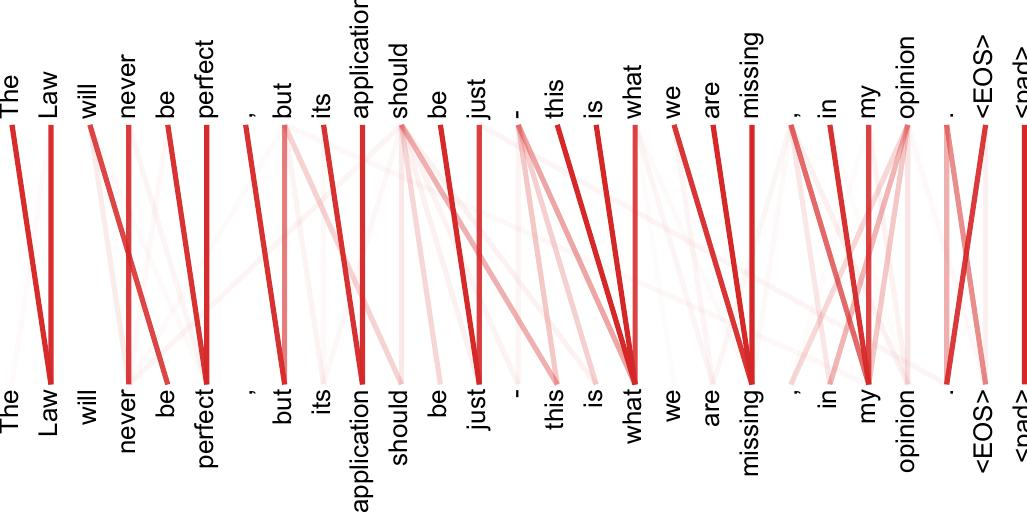

In [8]:
# Check retrieval

##### Test Images in the doc #####
##### What color is the softmax layer in the transformer model architecture diagram? #####
##### What color is the input embedding layer in the transformer model architecture diagram? #####
##### What layer comes after the optional Mask layer in the scaled dot-product attention block? #####

##### Test Tables in the doc #####
##### What is the BLEU score for ByteNet model? #####
##### What is the BLEU score for ConvS2S model? #####
##### What is the complexity of the Maximum Path Lengths for a convolutional layer type? #####

query = "What is the BLEU score for ByteNet model?"
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=6)
print('Number of relevant docs found:', len(docs))
print()

# Run RAG chain
response = chain_multimodal_rag.invoke(query)
print(response)
print()

# Show docs retrieved:
print('Documents retrieved:')
for doc in docs:
    if doc.startswith('/9j/'):
        display(Image.open(io.BytesIO(base64.b64decode(doc))))
    else:
        print()
        print(doc)

Number of relevant docs found: 4

Response:
The softmax layer in the transformer model architecture diagram is typically represented by a color that distinguishes it from other layers. However, without an actual image or diagram to reference, I cannot provide you with the specific color of the softmax layer.

In general, the softmax layer is often depicted as a separate block or highlighted in some way to indicate its function within the model architecture. The softmax function is used in neural networks for multi-class classification problems, where it converts the output of the previous layer into probabilities that sum up to 1. This allows the network to predict the class with the highest probability.

If you can provide me with an image or diagram of a transformer model architecture, I would be happy to help you identify the softmax layer and its color.

Documents retrieved:


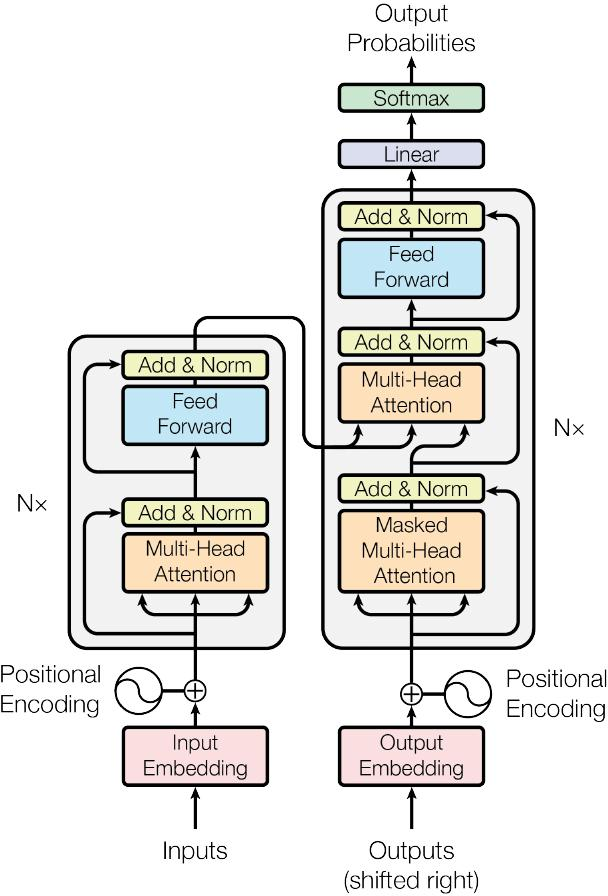

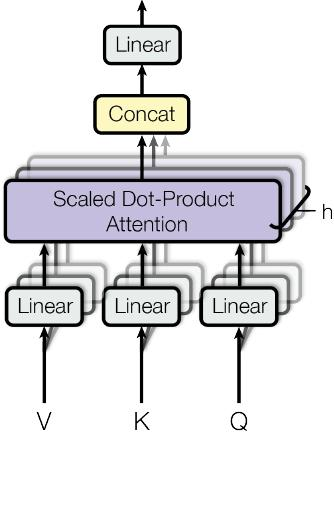

In [ ]:
query = "What color is the softmax layer in the transformer model architecture diagram?"
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=6)
print('Number of relevant docs found:', len(docs))
print()

# Run RAG chain
response = chain_multimodal_rag.invoke(query)
print('Response:')
print(response)
print()

# Show docs retrieved:
print('Documents retrieved:')
for doc in docs:
    if doc.startswith('/9j/'):
        display(Image.open(io.BytesIO(base64.b64decode(doc))))
    else:
        print()
        print(doc)
        